## Section. Data Statistics

## Figures:
1. jump-distance and arrival-time distribution


In [1]:
run import_library_data.ipynb

import done


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from scipy.optimize import curve_fit
import numpy as np

def linear_fun(x, a, b):
    return a * np.asarray(x) + b

def fitting_powerlaw(x, y ,x_line,base):
    #base=10
    popt, cov = curve_fit(linear_fun, np.log(x+0.000001)/np.log(base), np.log(y+0.000001)/np.log(base))
    a, b = popt
    y_line = linear_fun(np.log(x_line+0.000001)/np.log(base), a, b)
    y_line = np.power(base, y_line)

    return a,b, x_line, y_line

def fitting_linear(x, y ,base):
    #base=10
    popt, cov = curve_fit(linear_fun, x, y)
    a, b = popt
    y_line = linear_fun(x, a, b)

    return a, b, x, y_line

In [4]:
def set_fig_style(ax1, xlabel,ylabel,ratio):
    labelfont  = 14*ratio
    tickfont   = 14*ratio
    #tickfont   = 10*ratio
    legendfont = 14*ratio
    ax1.tick_params(axis='both', which='both', direction="in", labelsize=tickfont, pad=8 )
    for tick in ax1.xaxis.get_major_ticks(): tick.label.set_fontsize(tickfont)
    for tick in ax1.yaxis.get_major_ticks(): tick.label.set_fontsize(tickfont)

    ax1.set_xlabel(xlabel, fontsize=labelfont, labelpad=labelfont )
    ax1.set_ylabel(ylabel,fontsize=labelfont, labelpad=labelfont )
    #ax1.legend(loc='upper right', fontsize=legendfont, frameon=False)

    #ax1.spines.right.set_visible(False)
    #ax1.spines.top.set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

In [123]:
def jump_distance_distribution(df_list,label_list,color_list,path_figures):
    base=10
    fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))
    for data, label,color in zip(df_list, label_list,color_list):
        data['travel_d(km)'] = data['travel_d(km)'].astype('float')

        data=data[(data['travel_d(km)']<=2000)&(data['travel_d(km)']>=1)]
        data.dropna(subset=['travel_d(km)'])

        count, bins_count = np.histogram(data['travel_d(km)']+1, bins=100)
        pdf = count /np.sum(count)
        bins_count = np.array([(bins_count[i] + bins_count[i + 1]) / 2 for i in np.arange(len(bins_count) - 1)])
        
        numy=np.max([ num for num, x in enumerate(pdf) if x>1/10000])
            
        numx=np.max([ num for num, x in enumerate(pdf) if x>1/1000])
        
        if numx>=400:
            numx=10
        numx=10
        print(numx)
        a, b, xline, yline = fitting_powerlaw(bins_count[0:numx], pdf[0:numx],bins_count[0:numy],base)
        ax.scatter(bins_count[0:numy], pdf[0:numy], color=color,  s=10 ,label=label+' ('+r'$\alpha=$'+str(round(a,2))+')')
        ax.plot(xline, yline, color=color, linewidth=1)
            
    set_fig_style(ax, r'$\Delta r [km]$',r'$P(\Delta r)$',1)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    plt.tight_layout()
    ax.set_ylim(1/10000, 1)
    #ax.set_ylim(1 ,np.max(data['count'])*1.1)
    fig.savefig(path_figures, dpi=600)

In [108]:
def arrival_time_distribution(df_list,label_list,color_list,path_figures):
    base=10
    fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))
    for data,label,color in zip(df_list,label_list,color_list):
        data['stay_t(h)'] = data['stay_t(h)'].astype('float')
        data['stay_t(min)']=data['stay_t(h)']*60
        count, bins_count = np.histogram(data['stay_t(min)'], bins=100)
        pdf = count / np.sum(count)
        bins_count = np.array([(bins_count[i] + bins_count[i + 1]) / 2 for i in np.arange(len(bins_count) - 1)])
        
        numx=np.max([ num for num, x in enumerate(pdf) if x>1/1000])
        
        #numx=10
        print(numx)
        a, b, xline, yline = fitting_powerlaw(bins_count[0:numx], pdf[0:numx], bins_count,base)
        ax.scatter(bins_count, pdf, color=color, s=10, label=label+' ('+r'$\beta=$'+str(round(a,2))+')')
        ax.plot(xline, yline,color=color, linewidth=1)
    
    set_fig_style(ax, r'$\Delta t [min]$',r'$P(\Delta t)$',1)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    #ax.set_xlim(5 , 2000)
    ax.set_ylim(1/10000, 1)
    plt.tight_layout()
    fig.savefig(path_figures,dpi=600)

In [72]:

def haversine(points_a, points_b, radians=False):
    """
    Calculate the great-circle distance bewteen points_a and points_b
    points_a and points_b can be a single points or lists of points.

    Author: Piotr Sapiezynski
    Source: https://github.com/sapiezynski/haversinevec

    Using this because it is vectorized (stupid fast).
    """

    def _split_columns(array):
        if array.ndim == 1:
            return array[0], array[1]  # just a single row
        else:
            return array[:, 0], array[:, 1]

    if radians:
        lat1, lon1 = _split_columns(points_a)
        lat2, lon2 = _split_columns(points_b)

    else:
        # convert all latitudes/longitudes from decimal degrees to radians
        lat1, lon1 = _split_columns(np.radians(points_a))
        lat2, lon2 = _split_columns(np.radians(points_b))

    # calculate haversine
    lat = lat2 - lat1
    lon = lon2 - lon1

    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lon * 0.5) ** 2
    h = 2 * 6371 * np.arcsin(np.sqrt(d))
    return h  # in kilometers

# Cuebiq data

In [12]:
df,df_home,path_figures=raw_data_load('cuebiq')
df1 = df[df['month'] < 3] ###before covid-19 lockdwon
df2 = df[df['month'] >=3]####after covid-19 lockdwon

/Volumes/SeagateDrive/Mobility_Project/Cuebiq_data_results/Cuebiq_individual/
all files 40577


Cubiq Data====================
/Users/lucinezhong/Documents/LuZHONGResearch/20210328Scale_Mobility/Results_cuebiq/basic_statistics/
76
41


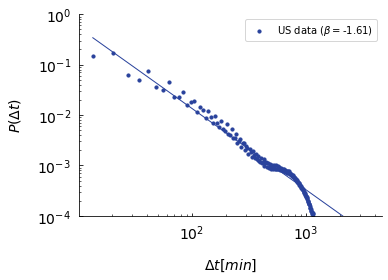

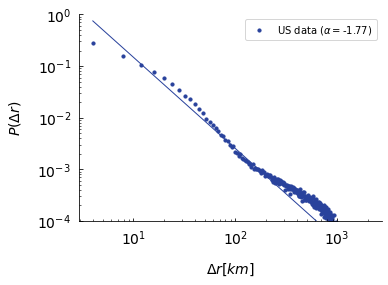

In [13]:
print('Cubiq Data====================')

path_figures='/Users/lucinezhong/Documents/LuZHONGResearch/20210328Scale_Mobility/Results_cuebiq/basic_statistics/'
print(path_figures)
color_list = ['#29429c', '#b2182b']
######jump-distance and arrival-time distribution

arrival_time_distribution([df], ['US data'], color_list,path_figures + 'delta_t(all).png')
jump_distance_distribution([df], ['US data'], color_list, path_figures + 'delta_r(all).png')


96
117
99
45
55
222


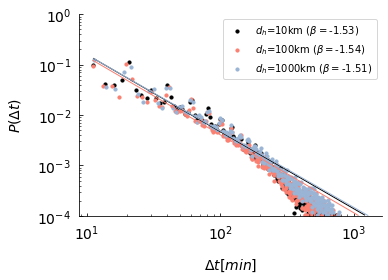

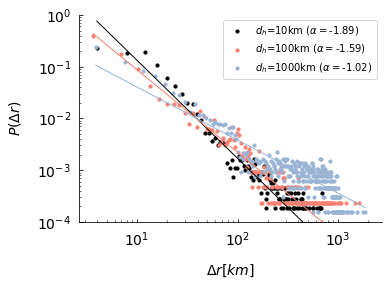

In [14]:
dfx=copy.deepcopy(df)

dfx['d_home_x']=np.log10(dfx['d_home']+1)
dfx['travel_d(km)_x']=np.log10(dfx['travel_d(km)']+1)

dfx=dfx.dropna()
dfx['d_home_x']=dfx['d_home_x'].astype(int)
dfx['travel_d(km)_x']=dfx['travel_d(km)_x'].astype(int)

dfx=dfx[(dfx['d_home_x']!=dfx['travel_d(km)_x'])&(dfx['d_home_x']!=dfx['travel_d(km)_x']-0.1)&(dfx['d_home_x']!=dfx['travel_d(km)_x']+0.1)]

df10km=dfx[(dfx['d_home']>10*0.5)&(dfx['d_home']<10*1.2)]
df100km=dfx[(dfx['d_home']>100*0.8)&(dfx['d_home']<100*1.2)]
df1000km=dfx[(dfx['d_home']>1000*0.8)&(dfx['d_home']<1000*1.2)]


color_list=['#000000','#fa8072','#9ab4d5','#8cd2c6','#edf7b5']

arrival_time_distribution([df10km,df100km,df1000km], [r'$d_h$'+'=10km',r'$d_h$'+'=100km',r'$d_h$'+'=1000km'], color_list,path_figures + 'delta_t(d_home).png')
jump_distance_distribution([df10km,df100km,df1000km], [r'$d_h$'+'=10km',r'$d_h$'+'=100km',r'$d_h$'+'=1000km'], color_list, path_figures + 'delta_r(d_home).png')


## Senegal data

In [29]:

df,df_home,path_figures=raw_data_load('senegal')
print(len(df))

1015101


Cubiq Data====================
/Users/lucinezhong/Documents/LuZHONGResearch/20210328Scale_Mobility/Results_senegal/basic_statistics/
55
76


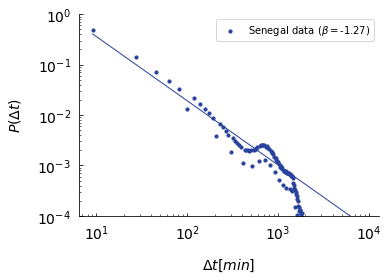

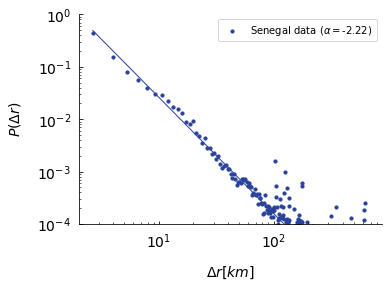

In [30]:
print('Cubiq Data====================')

path_figures='/Users/lucinezhong/Documents/LuZHONGResearch/20210328Scale_Mobility/Results_senegal/basic_statistics/'
print(path_figures)
color_list = ['#29429c', '#b2182b']
######jump-distance and arrival-time distribution

arrival_time_distribution([df], ['Senegal data'], color_list,path_figures + 'delta_t(all).png')
jump_distance_distribution([df], ['Senegal data'], color_list, path_figures + 'delta_r(all).png')

1015101
36
90
99
152


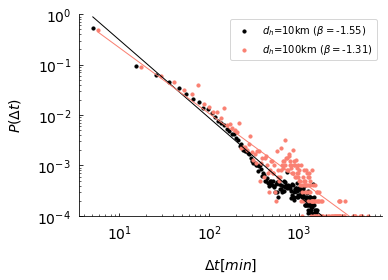

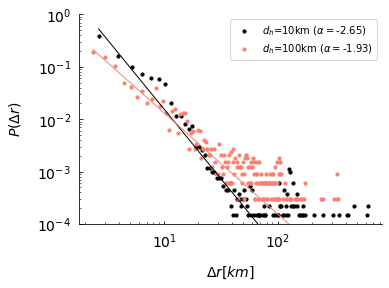

In [17]:
print(len(df))
dfx=copy.deepcopy(df)

dfx['d_home_x']=np.log10(dfx['d_home']+1)
dfx['travel_d(km)_x']=np.log10(dfx['travel_d(km)']+1)

dfx=dfx.dropna()
dfx['d_home_x']=dfx['d_home_x'].astype(int)
dfx['travel_d(km)_x']=dfx['travel_d(km)_x'].astype(int)

dfx=dfx[(dfx['d_home_x']!=dfx['travel_d(km)_x'])&(dfx['d_home_x']!=dfx['travel_d(km)_x']-0.1)&(dfx['d_home_x']!=dfx['travel_d(km)_x']+0.1)]

df10km=dfx[(dfx['d_home']>10*0.5)&(dfx['d_home']<10*2)]
df100km=dfx[(dfx['d_home']>100*0.8)&(dfx['d_home']<100*1.2)]

color_list=['#000000','#fa8072','#9ab4d5','#8cd2c6','#edf7b5']

arrival_time_distribution([df10km,df100km], [r'$d_h$'+'=10km',r'$d_h$'+'=100km'], color_list,path_figures + 'delta_t(d_home).png')
jump_distance_distribution([df10km,df100km], [r'$d_h$'+'=10km',r'$d_h$'+'=100km'], color_list, path_figures + 'delta_r(d_home).png')


# Ivory data

In [125]:
df_all=pd.read_csv('/Users/lucinezhong/Documents/LuZHONGResearch/20210328Scale_Mobility/Dataset/Ivory_Coast_data/ivory_all_usr_stoppoints.csv')

In [126]:
df_home = pd.read_csv(raw_path + 'Ivory_data_results/all_usr_home_sum.csv')
df_all=df_all.merge(df_home,on=['userid'],how='left')


In [127]:
print(df_all.head(5))

   Unnamed: 0_x  Unnamed: 0.1  userid                 time  site_id  \
0             0             0       1  2011-12-06 21:00:00      264   
1             1             1       1  2011-12-06 22:36:00      264   
2             2             2       1  2011-12-07 07:39:00      264   
3             3             3       1  2011-12-07 07:45:00      264   
4             4             4       1  2011-12-07 07:47:00      264   

   longitude  latitude  cnt            label        date  start_h  staytime  \
0  -4.040343  6.912917    0  8c751cb25ccc7ff  2011-12-06       21   80640.0   
1  -4.040343  6.912917    1  8c751cb25ccc7ff  2011-12-06       22   53820.0   
2  -4.040343  6.912917    2  8c751cb25ccc7ff  2011-12-07        7   86040.0   
3  -4.040343  6.912917    3  8c751cb25ccc7ff  2011-12-07        7   86280.0   
4  -4.040343  6.912917    4  8c751cb25ccc7ff  2011-12-07        7   85620.0   

   stay_t(h)  travel_d(km)  travel_bearing  Unnamed: 0_y       home_label  \
0  22.400000         

In [129]:

df_list=[]
count=0
######jump-distance and arrival-time distribution
for index,df_temp in df_all.groupby(['userid']):
    df_temp.sort_values(by=['date','start_h'])
    df_temp['time'] = list(map(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S'), df_temp['time']))
    df_temp['time'] = list(map(lambda x: x.timestamp(), df_temp['time']))
    df_temp1 = df_temp.shift(periods=-1)
    df_temp['stay_t(h)'] = list(map(lambda x: (x[1] - x[0])/3600 if math.isnan(x[0])==False or math.isnan(x[1])==False else 0 , zip(df_temp['time'], df_temp1['time'])))
    
    
    df_temp['travel_d(km)'] = list(map(lambda x: haversine((x[0], x[1]), (x[2], x[3])),
                                      zip(df_temp['latitude'], df_temp['longitude'], df_temp1['latitude'],
                                          df_temp1['longitude'])))
    
    df_temp['d_home'] = list(map(lambda x: haversine((x[0], x[1]), (x[2], x[3])),
                                      zip(df_temp['latitude'], df_temp['longitude'], df_temp1['home_lat'],
                                          df_temp1['home_lon'])))
    
    df_list.append(df_temp)
    count+=1
    #print(count)
    if count==1000:
        break
df=pd.concat(df_list)


Ivory Data====================
/Users/lucinezhong/Documents/LuZHONGResearch/20210328Scale_Mobility/Results_Ivory/basic_statistics/
0        1.600000
1        9.050000
2        0.100000
3        0.033333
4        0.216667
           ...   
98561    0.000000
98565    3.516667
98568    0.350000
98569    0.016667
98570    0.050000
Name: stay_t(h), Length: 86901, dtype: float64
22
10


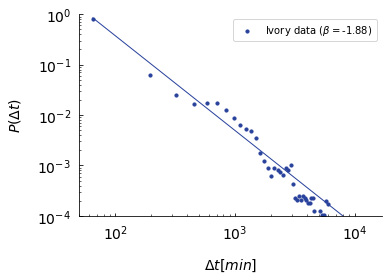

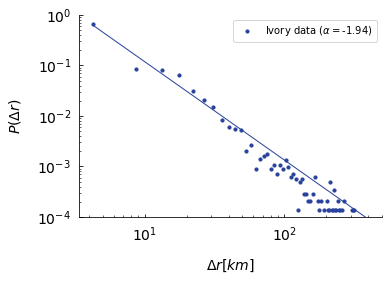

In [130]:
print('Ivory Data====================')

path_figures='/Users/lucinezhong/Documents/LuZHONGResearch/20210328Scale_Mobility/Results_Ivory/basic_statistics/'
print(path_figures)
color_list = ['#29429c', '#b2182b']


df=df.dropna(subset=['stay_t(h)','travel_d(km)'])
print(df['stay_t(h)'])
arrival_time_distribution([df], ['Ivory data'], color_list,path_figures + 'delta_t(all).png')
jump_distance_distribution([df], ['Ivory data'], color_list, path_figures + 'delta_r(all).png')

0
0


ValueError: zero-size array to reduction operation maximum which has no identity

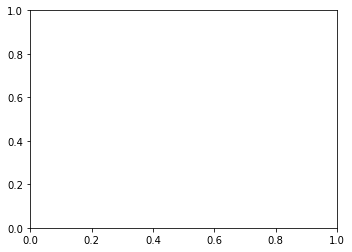

In [132]:
dfx=copy.deepcopy(df)
dfx=dfx.merge(df_home)

dfx['d_home_x']=np.log10(dfx['d_home']+1)
dfx['travel_d(km)_x']=np.log10(dfx['travel_d(km)']+1)

dfx=dfx.dropna()
dfx['d_home_x']=dfx['d_home_x'].astype(int)
dfx['travel_d(km)_x']=dfx['travel_d(km)_x'].astype(int)

dfx=dfx[(dfx['d_home_x']!=dfx['travel_d(km)_x'])&(dfx['d_home_x']!=dfx['travel_d(km)_x']-0.1)&(dfx['d_home_x']!=dfx['travel_d(km)_x']+0.1)]

df10km=dfx[(dfx['d_home']>10*0.5)&(dfx['d_home']<10*5)]
df100km=dfx[(dfx['d_home']>100*0.8)&(dfx['d_home']<100*5)]


color_list=['#000000','#fa8072','#9ab4d5','#8cd2c6','#edf7b5']

arrival_time_distribution([df10km,df100km], [r'$d_h$'+'=10km',r'$d_h$'+'=100km'], color_list,path_figures + 'delta_t(d_home).png')
jump_distance_distribution([df10km,df100km], [r'$d_h$'+'=10km',r'$d_h$'+'=100km'], color_list, path_figures + 'delta_r(d_home).png')
